<a href="https://colab.research.google.com/github/sourabhkmr/Personal-Projects/blob/main/EEMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pywt

deltaT = 0.001
maxmin_count = 0
mean_IMF = 1
iter = 0
nu = 1
NR = 20
noise_width = 0.01
n_IMF = 0
realization = 0
IMF = []
total_env_points = 10

f1 = 8
f2 = 24
f3 = 30
total_time = 2
time = np.arange(0, total_time + deltaT, deltaT)

sig1 = np.sin(2 * np.pi * f1 * time)
sig2 = np.sin(2 * np.pi * f2 * time)
sig3 = np.sin(2 * np.pi * f3 * time)
signal = 0.7*sig1 + 0.7*sig2 + 1.4*sig3

L = len(signal)
max_IMF = []
#np.random.seed(12345)

while realization < NR:
    scale = noise_width * np.abs(np.max(signal)-np.min(signal))
    noise = np.random.normal(loc=0, scale=scale, size=len(signal))
    sig_noise = signal + noise
    sig_mean = np.mean(sig_noise)
    sig_without_mean = sig_noise - sig_mean
    sig_ext = pywt.pad(sig_without_mean,(nu*L,nu*L),'antireflect')

    chi = []
    L_s = len(sig_ext)

    for x in range(L_s):
      if x < nu*L-1:
        chi.append(1/2*(np.cos(x*np.pi/nu/L-np.pi)+1))
      elif x < nu*L+L-1:
        chi.append(1)
      else:
        chi.append(1/2*(np.cos((L_s-x-1)*np.pi/nu/L-np.pi)+1))

    chi_array = np.asarray(chi)

    sig_mod = chi_array * sig_ext + sig_mean

    c = sig_mod

    x_coord = np.arange(0, len(sig_mod), 1)
    print(total_env_points, 'test')
    total_env_points = 10
    n_IMF = 0

    while total_env_points > 2 and n_IMF < 10:

        #sig_mean = np.mean(curr_sig)
        #sig_without_mean = curr_sig - sig_mean
        #sig_ext = pywt.pad(sig_without_mean,(L,L),'antireflect')

        #chi = []
        #L_s = len(sig_ext)

        #for x in range(L_s):
            #if x < L-1:
                #chi.append(1/2*(np.cos(x*np.pi/L-np.pi)+1))
            #elif x < 2 * L-1:
                #chi.append(1)
            #else:
                #chi.append(1/2*(np.cos((L_s-x-1)*np.pi/L-np.pi)+1))

        #chi_array = np.asarray(chi)
        #sig_mod = chi_array * sig_ext + sig_mean

        #c = sig_mod

        #x_coord = np.arange(0, len(sig_mod), 1)

        h = c
        total_std_dev = 1
        iter = 0

        while total_std_dev > 0.1 and iter < 50:

            location = []
            maxima_location = []
            minima_location = []
            maxima_points = []
            minima_points = []
            maxima_time = []
            minima_time = []

            maxima_location.append(0)
            minima_location.append(0)

            minima_total = 0
            maxima_total = 0
            zerocrossing_count = 0

            d = np.diff(h)

            i = 0

            for x in range(len(h)-2):
                if np.sign(d[x]) != np.sign(d[x+1]):
                    maxmin_count += 1
                    location.append(x+1)
                    i += 1

            location_array = np.asarray(location)

            if (len(location_array)) < 2:
              break
            i = location_array[0]
            j = location_array[1]

            if h[i] > h[j]:
                count = 0
                while count < len(location_array)-1:
                    maxima_location.append(location_array[count])
                    minima_location.append(location_array[count+1])
                    count += 2
            else:
                count = 0
                while count < len(location_array)-1:
                    maxima_location.append(location_array[count+1])
                    minima_location.append(location_array[count])
                    count += 2

            maxima_location.append(len(h)-1)
            minima_location.append(len(h)-1)

            maxima_location_array = np.asarray(maxima_location)
            minima_location_array = np.asarray(minima_location)

            for x in range(len(maxima_location_array)):
                i = maxima_location_array[x]
                maxima_points.append(h[i])
                maxima_time.append(x_coord[i])

            for x in range(len(minima_location_array)):
                i = minima_location_array[x]
                minima_points.append(h[i])
                minima_time.append(x_coord[i])

            maxima_points_array = np.asarray(maxima_points)
            minima_points_array = np.asarray(minima_points)
            maxima_time_array = np.asarray(maxima_time)
            minima_time_array = np.asarray(minima_time)

            cs_maxima = CubicSpline(maxima_time_array, maxima_points_array)
            cs_minima = CubicSpline(minima_time_array, minima_points_array)

            max_env = cs_maxima(x_coord)
            min_env = cs_minima(x_coord)

            mean = np.zeros(len(max_env))
            for x in range(len(max_env)):
                mean[x] = 0.5 * (max_env[x] + min_env[x])

            mode = h - mean
            prevh = h

            maxima_total = len(maxima_points_array) - 2
            minima_total = len(minima_points_array) - 2
            mean_IMF = np.mean(mode)

            total_std_dev = 0
            for x in range(len(h)):
                std_dev = ((prevh[x]-mode[x])**2) / (prevh[x]**2 + 0.000001)
                total_std_dev += std_dev

            h = mode
            iter += 1

            print(realization, n_IMF, iter, maxima_total, minima_total, mean_IMF, total_std_dev)

        IMF.append(h)
        c = c - h
        total_env_points = maxima_total + minima_total
        n_IMF += 1

        #for x in range(L):
            #curr_sig[x] = c[x+L]
    max_IMF.append(n_IMF)
    IMF_array = np.asarray(IMF)
    print(len(IMF_array))
    realization += 1

    #no_of_IMF = np.size(IMF_array, 0)
    #len_of_IMF = np.size(IMF_array, 1)
    #sum_IMF_array = np.zeros((no_of_IMF, len_of_IMF))

    #for x in range(len(IMF_array)):
        #sum_IMF_array += IMF_array

len_of_IMF = np.size(IMF_array, 1)
max_IMF_array = np.asarray(max_IMF)
IMF_eemd = np.zeros((max_IMF_array[0],len_of_IMF))

for x in range(max_IMF_array[0]):
    for incr in range(len(IMF_array)):
        if (incr-x) % max_IMF_array[0] == 0:
            IMF_eemd[x,:] += IMF_array[x,:]

IMF_eemd = IMF_eemd/NR
print(max_IMF_array)

Streaming output truncated to the last 5000 lines.
9 0 26 2083 2083 6.272662093694219e-06 17.55334431158802
9 0 27 2083 2083 6.345314692329665e-06 22.46755126726331
9 0 28 2085 2085 6.2107348573080365e-06 18.93285729085052
9 0 29 2088 2088 4.9476604795245815e-06 24.41834085459077
9 0 30 2089 2089 3.5790539531648583e-06 10.10801423322749
9 0 31 2089 2089 8.4995640291721e-07 4.703843418383288
9 0 32 2089 2089 -3.024653974067815e-07 3.2129122784756543
9 0 33 2089 2089 -5.453794461560477e-07 2.791702068412905
9 0 34 2089 2089 8.140357371553717e-07 3.161371842404094
9 0 35 2089 2089 2.0535678850049344e-06 4.135989017508692
9 0 36 2089 2089 9.364799758597778e-07 3.32720730504902
9 0 37 2091 2091 -2.5766737400116235e-07 8.36622044853449
9 0 38 2091 2091 7.005123063774318e-07 5.264886321329167
9 0 39 2091 2091 -1.2322078349207076e-07 3.2874031502105585
9 0 40 2093 2093 9.89072051816753e-06 24.132857815371512
9 0 41 2098 2098 1.0271433806855501e-05 97.59643019999186
9 0 42 2098 2098 9.630401262

output0


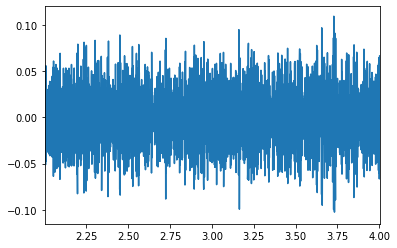

0.10930336328023374 -0.1043468673609103
output1


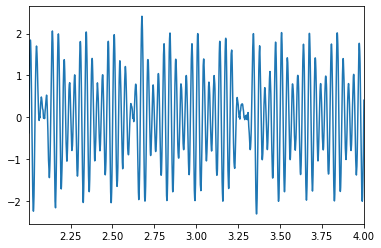

2.4128883458807984 -2.315550701177123
output2


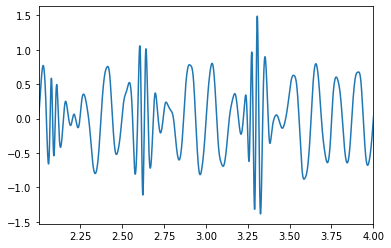

1.4866570305628206 -1.3842490156221146
output3


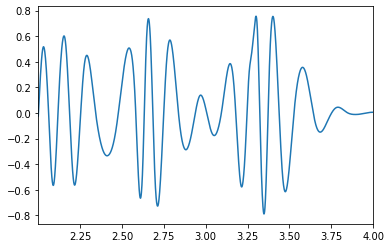

0.7562528951101305 -0.7884876720424465
output4


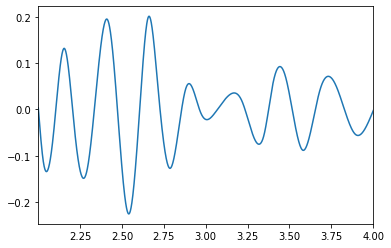

0.20188254844158104 -0.22609778377477355
output5


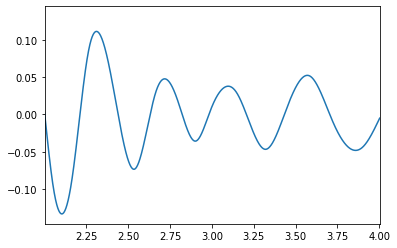

0.13155166365626228 -0.13345955415764282
output6


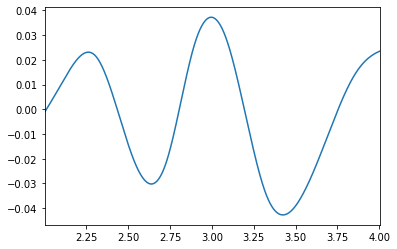

0.0371906583996711 -0.04272383870949484
output7


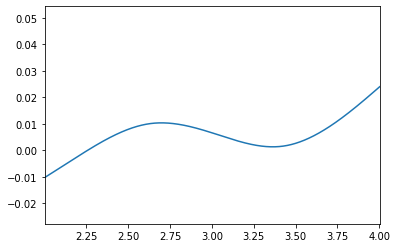

0.050662097911600944 -0.024012552497961505
output8


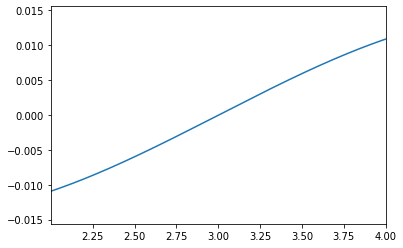

0.01417102210779461 -0.014179202175671186


In [ ]:
time_mod = x_coord * deltaT
xlim_min = nu * L * deltaT
xlim_max = (nu * L + L - 1) * deltaT
for x in range(len(IMF_eemd)):
  fname = "output" + str(x)
  print(fname)
  plt.plot(time_mod, IMF_eemd[x,:])
  plt.xlim(xlim_min,xlim_max)
  plt.show()
  plt.close()
  print(np.max(IMF_eemd[x,:]),np.min(IMF_eemd[x,:]))

#plt.plot(time_mod,c_noise)
#plt.xlim(3.4,3.8)
#plt.show()
#plt.close()

#plt.plot(time_mod,c)
#plt.xlim(3.4,3.8)
#plt.show()
#plt.close()

#plt.plot(time_mod,c_diff)
#plt.show()

In [ ]:
for x in range(10):
  fname = "output" + str(x)
  print(fname)

output0
output1
output2
output3
output4
output5
output6
output7
output8
output9
